In [20]:
###############################################################################
#
#   Symmetric Chain Decomposition of Random Peck Posets
#   by Charles Troutman III
#   Date: July 30, 2023
#
#   This script generates a specific number of posets with a desired number of ranks, 
#   and a maximum and minimum rank size. Each poset is evaluated and undergoes noise reduction. 
#   The script also calculates the Symmetric Chain Decomposition of each poset.
# 
#   For inquiries, please email: charles[at]charlestroutman3[dot]com
#
###############################################################################

from sage.combinat.posets.posets import Poset
from sage.combinat.partition import Partition
from sage.plot.colors import chocolate
import random

In [39]:
class PosetAnalyzer:
    """
    This class is used for analyzing posets (partially ordered sets).
    Provided is a collection of methods for generating random posets,
    and analyzing certain properties of them.

    """

    def __init__(self, vertices, rank_sizes, covering_relations):
        """
        Initializes a new instance of the PosetAnalyzer class.
        
        A poset is defined by:
        vertices: the elements of the poset.
        rank_sizes: the sizes of each rank in the poset (width).
        covering_relations: the relations(edges) that dictate the order in the poset. 
        """
        self.vertices = vertices
        self.rank_sizes = rank_sizes
        self.covering_relations = covering_relations

        
    def get_current_poset(self):
        """
        Returns the poset represented by self.vertices and self.covering_relations.
        """
        # Poset is constructed using vertices and covering relations
        return Poset((self.vertices, self.covering_relations))

    """
    ----------------------------------------------
    Section 1: General Use Functions
    ----------------------------------------------
    """

    def split_ranks(self): 
        """
        Given a list of rank sizes and vertices,
        indicate which vertices will be placed on which rank.

        OUTPUTS:
        A list of lists, where each sublist represents a rank and its vertices.
        """
        ranks = []
        counter = 0
        # Iterate over the rank sizes
        for current_rank_size in self.rank_sizes:
            # Slice the list of vertices to get the current rank
            current_rank_list = self.vertices[counter:counter + current_rank_size]
            counter += current_rank_size
            # Add the current rank to the list of ranks
            ranks.append(current_rank_list)
        return ranks

    @staticmethod
    def make_vertices(rank_size_list):
        """
        Given a list of rank sizes, output a list of integers (vertices) with length equal to the sum of the ranks.

        INPUTS:
        rank_size_list: a list of integers, each representing the size of a rank.

        OUTPUTS:
        A list of integers from 0 to the total number of vertices minus one.
        """
        # Calculate total number of vertices
        total_number_of_vertices = sum(rank_size_list)
        # Create a list of integers from 0 to total_number_of_vertices - 1
        vertices = list(range(total_number_of_vertices))
        return vertices

    def possible_covering_relations(self, ranks_list):
        """
        Returns all possible covering relations between vertices in ranked_vertex_list.

        INPUTS:
        ranks_list: a list of lists, where each sublist represents a rank and contains its vertices.

        OUTPUTS:
        A dictionary mapping each vertex to its possible covering vertices.
        """
        relations = {}
        # Iterate over the ranks
        for r, rank_list in enumerate(ranks_list):
            # Skip the first (bottom) rank as it can't cover any vertex
            if r == 0:
                continue
            # For each vertex in the previous rank, set the current rank as its possible covering vertices
            for vertex in ranks_list[r - 1]:
                relations[vertex] = set(rank_list)
        # Make first rank's possible covering vertices an empty set
        for vertex in ranks_list[-1]:
            relations[vertex] = set()
        return relations


    # Acknowledgment: Thanks to Joshua Mundinger for his contributions to 
    # the definition of the is_strong function, which is essential in determining
    # whether a random Poset is Peck.
    @staticmethod
    def is_strong(poset, rank_size_list):
        """
        Given a poset, returns whether or not the poset is strongly Sperner
        INPUTS:
        poset: a Poset
        rank_size_list: a list of ranks
        OUTPUTS:
        whether P is strongly Sperner
        """
        #compute the Greene-Kleitman invariant of the poset
        greene_kleitman = poset.greene_shape()
        max_antichain_union_sizes = list(Partition(greene_kleitman).conjugate())
        #compare to the list of ranks, sorted
        return max_antichain_union_sizes == sorted(rank_size_list,reverse = True)
        
    """
    ----------------------------------------------
    Section 2: Random Generation
    ----------------------------------------------
    """

    def generate_random_rank_sizes(self, number_of_ranks, max_rank_size, min_rank_size):
        """
        Given a number of ranks and bounds on the sizes of ranks,
        randomly generate a symmetric unimodal list of ranks
        within the constraints.

        INPUTS:
        number_of_ranks: integer
        max_rank_size: integer
        min_rank_size: integer

        OUTPUTS:
        list of integers
        """
        # Compute the number of top ranks. Add 1 to handle odd numbers correctly.
        top_ranks_size = (number_of_ranks + 1) // 2

        # Initialize empty lists for top and bottom ranks.
        top_ranks = [] 
        bottom_ranks = []

        # Populate the ranks with random values within the given size range.
        for _ in range(top_ranks_size):
            rank_size = random.randint(min_rank_size, max_rank_size)
            top_ranks.append(rank_size)
            bottom_ranks.append(rank_size)

        # Sort bottom ranks in ascending order and top ranks in descending order.
        # This ensures that the list of ranks is symmetric and unimodal.
        bottom_ranks.sort()
        top_ranks.sort(reverse=True)

        # If the number of ranks is odd, remove the largest element from the top.
        # This is done because in a symmetric list, the peak should only occur once.
        if number_of_ranks % 2:
            top_ranks.pop(0) 

        # Concatenate the bottom and top ranks to get the final list.
        total_ranks = bottom_ranks + top_ranks

        return total_ranks

    def find_sublist_index(self, list_of_lists, element):
        """
        Given a list of lists, find the index of the sublist that contains a given element.
        
        INPUTS:
        list_of_lists: list of lists
        element: the element to search for

        OUTPUTS:
        The index of the sublist that contains the element. If the element is not found, the function returns None.
        """
        for index, sublist in enumerate(list_of_lists):
            if element in sublist:
                return index



    def generate_random_Peck_poset(self, rank_size_list):
        """
        Generates a random Peck poset with ranks given by rank_size_list that are symmetric and unimodal. 
        Thus, the logic remains to randomly add an edge until the Poset is strongly sperner.

        INPUTS:
        rank_size_list: a list of ranks.
        OUTPUTS:
        a Peck poset
        """
        # Generate the vertices based on the size of the ranks.
        vertices = self.make_vertices(rank_size_list)

        # Split the ranks into distinct groups.
        ranks_list = self.split_ranks()

        # Get all the possible covering relations between the vertices.
        possible_relations = self.possible_covering_relations(ranks_list)

        # Initialize an empty set for covering relations, using set for efficient membership operations.
        covering_relations = set()

        # Create a poset with the generated vertices and no relations (to start with).
        P = Poset((vertices, list(covering_relations)), cover_relations=True, facade=False)

        # Keep adding random edges until the poset satisfies the condition defined by is_strong method.
        while not self.is_strong(P, rank_size_list):
            # Select a random vertex excluding those in the last rank.
            a = random.randrange(len(vertices) - rank_size_list[-1])

            # Get the vertices that can be covered by the selected vertex.
            possible_covers = list(possible_relations[vertices[a]])

            if possible_covers:
                # Select one of the possible cover vertices at random.
                b = random.randrange(len(possible_covers))

                # Randomly generate an edge
                edge = (a, possible_covers[b])

                # Check if this edge has already been included.
                if edge not in covering_relations:
                    # Add the edge to the set of relations.
                    covering_relations.add(edge)

            # Update the poset with new set of relations. Convert covering_relations to list because the poset API requires it in this format.
            P = Poset((vertices, list(covering_relations)), cover_relations=True, facade=False)

        # Final poset construction after the while loop.
        P = Poset((vertices, list(covering_relations)), cover_relations=True, facade=False)
        
        # print(f"RANDOM: {vertices}, {covering_relations}")
        return P, vertices, list(covering_relations), rank_size_list

    """
    ----------------------------------------------
    Section 3: Poset Analysis
    ----------------------------------------------
    """

    def is_saturated(self, chain):
        """
        Given a chain of vertices, determines if the chain is saturated.
        A chain is saturated it cannot be internally extended (does not skip a rank).

        INPUTS:
        chain: a list of vertices

        OUTPUTS:
        boolean: True if the chain is saturated, False otherwise
        """
        # Create a list of ranks corresponding to the vertices in the chain
        ranks = [self.vertex_rank(vertex) for vertex in chain]

        # Check if the difference in ranks between every adjacent pair of vertices in the chain is 1
        # If yes, then the chain is saturated
        return all(ranks[i] + 1 == ranks[i + 1] for i in range(len(ranks) - 1))

    def is_symmetric(self, chain, max_rank):
        """
        Given a chain of vertices and the maximum rank in the poset,
        determines if the chain is symmetric with respect to the center of the poset.

        INPUTS:
        chain: a list of vertices
        max_rank: integer, the maximum rank in the poset

        OUTPUTS:
        boolean: True if the chain is symmetric, False otherwise
        """
        # Calculate the rank of the first vertex in the chain
        first_rank = self.vertex_rank(chain[0])

        # Calculate the rank of the last vertex in the chain
        last_rank = self.vertex_rank(chain[-1])

        # Check if the sum of the first and last rank equals the maximum rank
        # If yes, then the chain is symmetric
        return first_rank + last_rank == max_rank

    def symmetric_chains(self, P):
        """
        Given a poset P, finds all chains in P that are both saturated and symmetric.

        INPUTS:
        P: a poset

        OUTPUTS:
        saturated_symmetric_chains: a list of chains, each chain is a list of vertices
        """
        # Get all chains from the poset excluding the empty chain
        all_chains = list(P.chains()[1:])

        # Get the maximum rank of the poset
        max_rank = len(self.rank_sizes) - 1

        # Initialize the list of saturated symmetric chains
        saturated_symmetric_chains = []

        # Determine whether the number of ranks is odd
        is_odd = len(self.rank_sizes) % 2 == 1

        # For each chain in all_chains, check if it is both saturated and symmetric
        # If the number of ranks is odd, only add chains of odd length
        # If the number of ranks is even, only add chains of even length
        for chain in all_chains:
            if self.is_saturated(chain) and self.is_symmetric(chain, max_rank):
                if is_odd and len(chain) % 2 == 1:
                    saturated_symmetric_chains.append(chain)
                elif not is_odd and len(chain) % 2 == 0:
                    saturated_symmetric_chains.append(chain)

        # Return the list of saturated symmetric chains
        return saturated_symmetric_chains

        
    def compute_vertex_covering_relations(self):
        """
        Precomputes the covering relations for each vertex.

        OUTPUTS:
        A dictionary mapping each vertex to a list of its covering relations.
        """
        # Initialize a dictionary with an empty list for each vertex
        vertex_covering_relations = {vertex: [] for vertex in self.vertices}
        
        # Fill the dictionary by iterating over the covering relations
        for relation in self.covering_relations:
            for vertex in relation:
                # Add the current relation to the list of the current vertex
                vertex_covering_relations[vertex].append(relation)

        return vertex_covering_relations

    def vertex_rank(self, vertex): 
        """
        Returns the rank of the given vertex.

        INPUTS:
        vertex: a vertex.

        OUTPUTS:
        The rank of the vertex.
        """
        # The rank of a vertex is the index of the sublist it belongs to in the list of ranks
        return next(i for i, sublist in enumerate(self.split_ranks()) if vertex in sublist)

    def degree(self, vertex): 
        """
        Returns the degree of the given vertex.

        INPUTS:
        vertex: a vertex.

        OUTPUTS:
        The degree of the vertex.
        """
        # The degree of a vertex is the number of relations it is involved in
        return sum(vertex in relation for relation in self.covering_relations)

    def scope_degree(self, vertex, low_rank, high_rank): 
        """
        Returns the number of relations of the given vertex that involve only vertices with ranks within the given range (scope).

        INPUTS:
        vertex: a vertex.
        low_rank: the lower bound of the range.
        high_rank: the upper bound of the range.

        OUTPUTS:
        The number of relations within the given range.
        """
        # Compute the covering relations for each vertex
        vertex_covering_relations = self.compute_vertex_covering_relations()
        
        # Filter the relations of the vertex to include only those that involve vertices with ranks within the given range
        covering_relations = [
            relation for relation in vertex_covering_relations[vertex]
            if all(low_rank <= self.vertex_rank(v) <= high_rank for v in relation)
        ]
        
        # The degree of the vertex within the given range is the number of filtered relations it is involved in
        return sum(vertex in relation for relation in covering_relations)


In [40]:
class NoiseReducer:
    """
    This class is used to reduce noise in posets (partially ordered sets).
    Noise can be considered as the unnecessary relations in a poset that do not contribute to the structure when searching for a Symmetric Chain Decomposition.

    An instance of this class uses an instance of the PosetAnalyzer class to perform operations on the poset.
    """

    def __init__(self, vertices, rank_size_list, cover_relations):
        """
        Initializes a new instance of the NoiseReducer class.
        
        Instance variables:
        analyzer: an instance of the PosetAnalyzer class
        covering_relations: a list of pairs of vertices, each pair (a, b) represents a relation where a < b
        rank_list: a list of ranks in the poset, each rank is a list of vertices
        vertices: a list of vertices of the poset
        rank_size_list: a list of integers representing the sizes of ranks of the poset

        """
        self.analyzer = PosetAnalyzer(vertices, rank_size_list, cover_relations)
        # Initilaizing a copy just in case we need to view the original number of edges
        self.covering_relations = cover_relations.copy()
        self.rank_list = self.analyzer.split_ranks()
        self.vertices = vertices
        self.rank_size_list = rank_size_list
        
    def connected_poset(self, vertices, covering_relations):   
        """
        Determines whether a Poset is connected.

        INPUTS: vertices, edges
        vertices: list, the elements of the poset

        OUTPUTS:
        Whether the graph representation of the poset is connected
        """
        # Create the graph
        G = Graph(covering_relations)

        # Add the vertices to the graph
        G.add_vertices(vertices)

        return G.is_connected()

    def annihilate(self, vertex, survivor, scope):
        """
        Removes all relations of the given vertex within the given scope,
        and if there is a survivor, adds it to the covering relations.

        INPUTS:
        vertex: The vertex to be annihilated.
        survivor: The tuple representing the new relation to be added after the vertex is annihilated.
        scope: The scope within which the annihilation should take place.

        OUTPUTS:
        A list of the new set of covering relations after the annihilation.
        """
        # Removes all relations involving 'vertex' within 'scope'
        self.covering_relations = [
            relation for relation in self.covering_relations
            if vertex not in relation or self.analyzer.vertex_rank(next(v for v in relation if v != vertex)) not in scope
        ]
        # If there is a survivor, add it to the covering relations
        if survivor is not None:
            self.covering_relations.append(survivor)
        # Check if the modified poset is still connected
        if self.connected_poset(self.vertices, self.covering_relations):
            return self.covering_relations
        return self.covering_relations

    def perform_cutting(self, mid):
        """
        Performs cuts on vertices in the middle rank that have degree 0 in the scope of mid-1 to mid+1.

        INPUTS:
        mid: The index of the middle rank.

        OUTPUTS:
        None
        """
        # Get all vertices in the middle rank that have degree 0 in the scope from mid-1 to mid+1
        to_cut = [vertex for vertex in self.rank_list[mid] if self.analyzer.scope_degree(vertex, mid, mid+1) == 0 or self.analyzer.scope_degree(vertex, mid-1, mid) == 0]
        # Perform the cuts
        for victim in to_cut:
            self.annihilate(victim, None, [mid-1,mid+1])


    def edge_reduction(self, scope, odd_ranks):
        """
        Reduces edges (relations) in the poset within a given scope.

        INPUTS:
        scope: The scope within which to perform the edge reduction. 
        odd_ranks: A flag indicating whether the total number of ranks is odd.

        OUTPUTS:
        None
        """
        # Create a list from the scope range
        scope_range = list(range(scope[0],scope[1]+1))
        # Find the ranks within the scope range
        relevant_rank_list = [rank for i, rank in enumerate(self.rank_list) if i in scope_range]
        
        # Calculate the middle rank, assuming an odd number of ranks
        middle = (len(self.rank_size_list)-1)//2 
        
        # Find vertices within the relevant ranks where the degree of scope is 1 and they are not in the middle rank (when the number of ranks is odd)
        to_swipe = [
            vert for rank in relevant_rank_list 
            for vert in rank 
            if self.analyzer.scope_degree(vert, scope[0], scope[1]) == 1 
            and (not odd_ranks or self.analyzer.vertex_rank(vert) != middle)
        ]

        # If there are vertices to process
        if to_swipe:
            # For each vertex
            for vertex in to_swipe.copy():
                # Find the only relation of the vertex within the scope range
                only_relation = next((relation for relation in self.covering_relations if vertex in relation and all(self.analyzer.vertex_rank(v) in scope_range for v in relation)), None)
                if only_relation is None:
                    continue

                # Find the partner vertex of the relation
                partner = only_relation[0] if only_relation[0] != vertex else only_relation[1]
                
                # If the number of ranks is odd and the rank of the partner is middle
                if odd_ranks and self.analyzer.vertex_rank(partner) == (len(self.rank_size_list)-1)//2: 
                    # If the degree of the partner is 2
                    if self.analyzer.degree(partner) == 2: 
                        # Find the other relation of the partner where the vertex is not a part
                        only_other_relation = next((relation for relation in self.covering_relations if partner in relation and vertex not in relation), None)
                        if only_other_relation is None:
                            continue

                        # Find the other partner of the relation
                        other_partner = only_other_relation[0] if only_other_relation[0] != vertex else only_other_relation[1]
                        # Remove the other relation and replace it with the only other relation
                        self.covering_relations = self.annihilate(other_partner, only_other_relation, scope)
                else:
                    # Remove the partner and replace it with the only relation
                    self.covering_relations = self.annihilate(partner, only_relation, scope)
                # Remove the processed vertex from the list
                to_swipe.remove(vertex)
        return None


    def noise_reduce(self, P):
        """
        Reduces noise in the poset 'P' by performing edge_reduction on each bipartite subgraph of the Poset.

        INPUTS:
        P: The poset to be reduced.

        OUTPUTS:
        The vertices, covering relations, and rank sizes of the poset after noise reduction.
        """
        # Save the initial length of covering_relations for later comparison
        original_len = len(self.covering_relations)

        # Check if the total number of ranks is odd
        is_odd = len(self.rank_size_list) % 2 == 1

        # Different operations are performed depending on whether the total number of ranks is odd or even
        if is_odd:
            mid = (len(self.rank_size_list)-1)//2

            #This manuevering before the formal Zig-Zag is a nice subtlety that ensures we reduce everything
            self.perform_cutting(mid)
            self.edge_reduction([mid, mid+1], True)
            self.edge_reduction([mid-1, mid], True)
            self.perform_cutting(mid)

            #Zig-Zag
            for i in range(mid):
                self.edge_reduction([mid + i, mid + i + 1], True)
                self.edge_reduction([mid - i - 1, mid - i], True)
        else:
            mid = len(self.rank_size_list)//2

            #Reducing the middle rank
            self.edge_reduction([mid-1, mid], False)

            #Zig-Zag
            for i in range(mid-1):
                self.edge_reduction([mid+i, mid + i + 1], True)
                self.edge_reduction([mid - i - 2, mid - i - 1], True)

        # Create the final poset and display it
        P_final = Poset((self.vertices, self.covering_relations), cover_relations=True, facade=False)
        show(P_final.plot(vertex_colors='darkgreen', edge_color='black'))

        # Calculate and print the number of edges reduced
        num_reduced = original_len - len(self.covering_relations)
        if num_reduced > 0:
            print(f"Number of Edges/Amount of Noise Removed: {num_reduced}")
        else:
            print("No Extraneous Edges")
        # print(f"REDUCED: {self.vertices}, {self.covering_relations}")
        return self.vertices, self.covering_relations, self.rank_size_list



 

In [24]:
    def find_SCD_BF(symmetric_chains, chain_sizes, used_vertices=set(), current_partition=[]):
        """
        Brute Forces an Symmetric Chain Decomposition of a poset. Through recursively selecting proper chain sizes.

        INPUTS:
        symmetric_chains: The symmetric chains in the poset.
        chain_sizes: The sizes of the chains to be found.
        used_vertices: The vertices that have already been included in a chain (default is an empty set).
        current_partition: The current partition of chains (default is an empty list).

        """
        # If there are no more sizes to find, we have a valid partition
        if not chain_sizes:
            return current_partition

        # Get the size of the next chain to find
        current_size = chain_sizes[0]

        # Get all chains of the current size
        chains_of_current_size = [chain for chain in symmetric_chains if len(chain) == current_size]

        for chain in chains_of_current_size:
            # If the chain shares a vertex with a previously selected chain, skip it
            if any(vertex in used_vertices for vertex in chain):
                continue

            # If the chain is valid, add it to the partition and update the used vertices
            new_partition = current_partition + [chain]
            new_used_vertices = used_vertices | set(chain)

            # Try to find the remaining chains with the new partition and used vertices
            result = find_SCD_BF(symmetric_chains, chain_sizes[1:], new_used_vertices, new_partition)

            # If a valid partition was found, return it
            if result:
                return result

        # If no valid partition was found after checking all chains of the current size, return None
        return None

---------------------------------------
Generated poset 1
Chain Sizes for the Symmetric Chain Decomposition Would Be: [7, 7, 5, 5, 1]


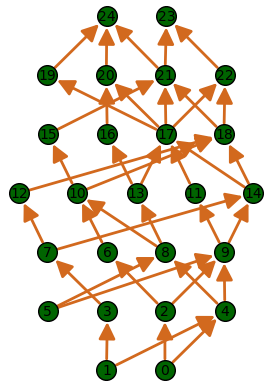

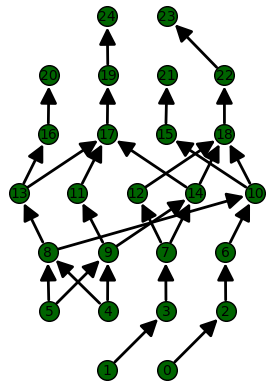

Number of Edges/Amount of Noise Removed: 10
Percentage reduction of symmetric chains by preprocessing step: 73.51%
No valid SCD found
---------------------------------------
Generated poset 2
Chain Sizes for the Symmetric Chain Decomposition Would Be: [7, 7, 3, 1]


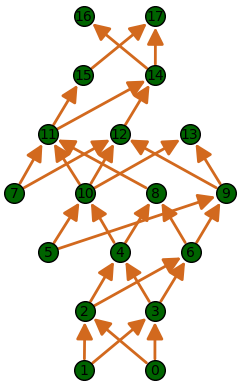

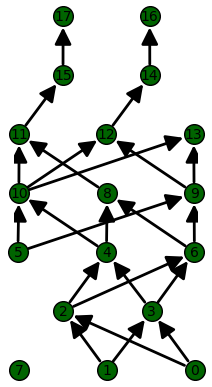

Number of Edges/Amount of Noise Removed: 4
Percentage reduction of symmetric chains by preprocessing step: 45.24%
Found SCD:
[1, 2, 4, 10, 12, 14, 16]
[0, 3, 6, 8, 11, 15, 17]
[5, 9, 13]
[7]
---------------------------------------
Generated poset 3
Chain Sizes for the Symmetric Chain Decomposition Would Be: [7, 7, 5, 5, 3, 1]


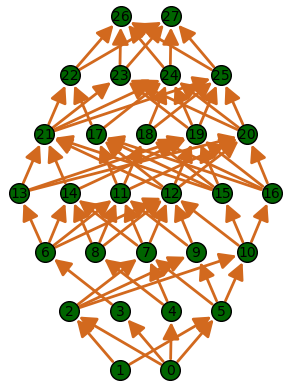

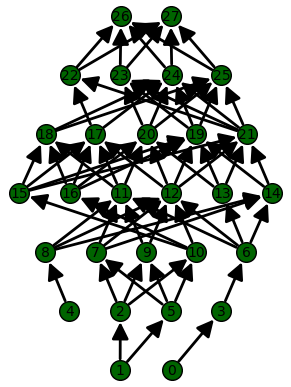

Number of Edges/Amount of Noise Removed: 4
Percentage reduction of symmetric chains by preprocessing step: 40.22%
Found SCD:
[1, 2, 7, 11, 18, 24, 26]
[0, 3, 6, 13, 20, 23, 27]
[4, 8, 14, 19, 25]
[5, 9, 12, 17, 22]
[10, 15, 21]
[16]
---------------------------------------
Generated poset 4
Chain Sizes for the Symmetric Chain Decomposition Would Be: [7, 7, 5]


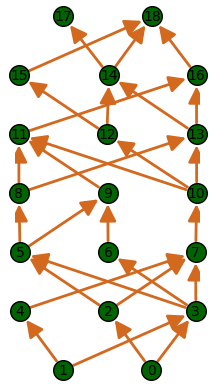

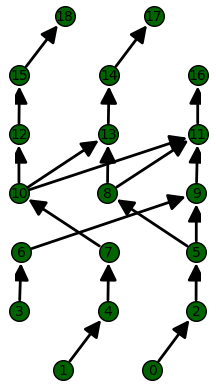

Number of Edges/Amount of Noise Removed: 9
Percentage reduction of symmetric chains by preprocessing step: 74.68%
Found SCD:
[1, 4, 7, 10, 12, 15, 18]
[0, 2, 5, 8, 13, 14, 17]
[3, 6, 9, 11, 16]
---------------------------------------
Generated poset 5
Chain Sizes for the Symmetric Chain Decomposition Would Be: [7, 7, 5, 5, 1, 1]


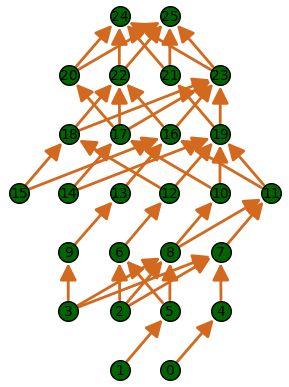

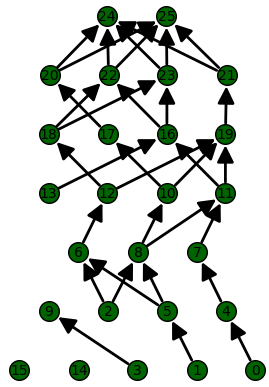

Number of Edges/Amount of Noise Removed: 10
Percentage reduction of symmetric chains by preprocessing step: 43.88%
No valid SCD found
---------------------------------------
Generated poset 6
Chain Sizes for the Symmetric Chain Decomposition Would Be: [7, 7, 5, 5, 3, 3]


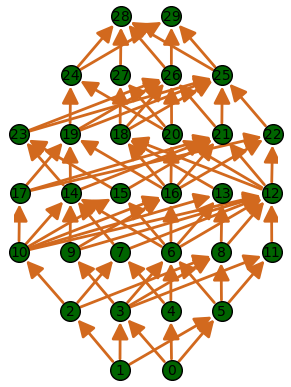

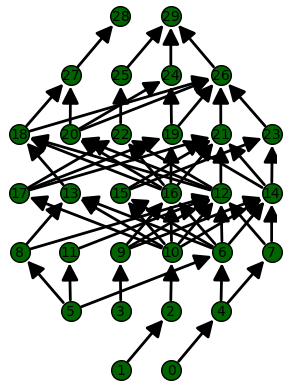

Number of Edges/Amount of Noise Removed: 16
Percentage reduction of symmetric chains by preprocessing step: 76.18%
No valid SCD found
---------------------------------------
Generated poset 7
Chain Sizes for the Symmetric Chain Decomposition Would Be: [7, 7, 5, 5, 3, 1]


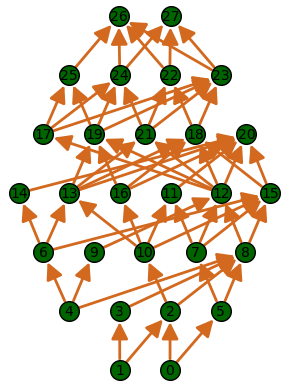

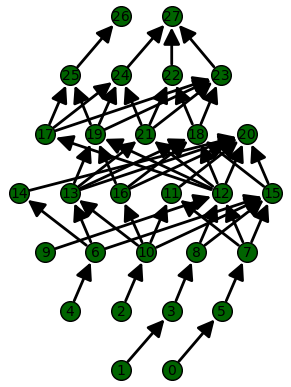

Number of Edges/Amount of Noise Removed: 9
Percentage reduction of symmetric chains by preprocessing step: 62.5%
No valid SCD found
---------------------------------------
Generated poset 8
Chain Sizes for the Symmetric Chain Decomposition Would Be: [7, 7, 7, 5, 5, 3]


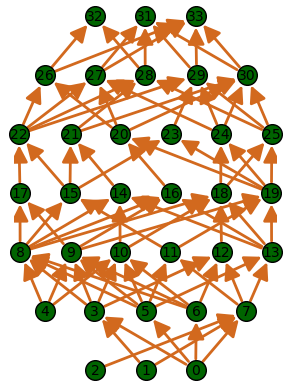

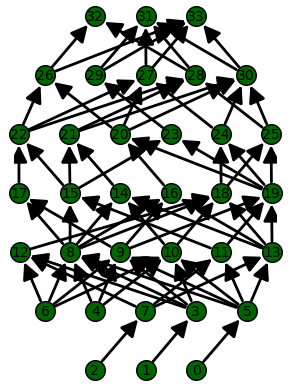

Number of Edges/Amount of Noise Removed: 7
Percentage reduction of symmetric chains by preprocessing step: 48.04%
Found SCD:
[2, 7, 12, 18, 24, 27, 31]
[1, 3, 8, 17, 22, 26, 32]
[0, 5, 11, 15, 23, 29, 33]
[6, 9, 16, 20, 30]
[4, 10, 14, 21, 28]
[13, 19, 25]
---------------------------------------
Generated poset 9
Chain Sizes for the Symmetric Chain Decomposition Would Be: [7, 7, 5, 5, 5, 1]


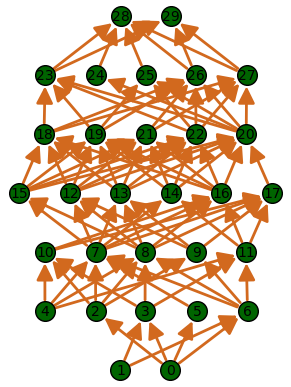

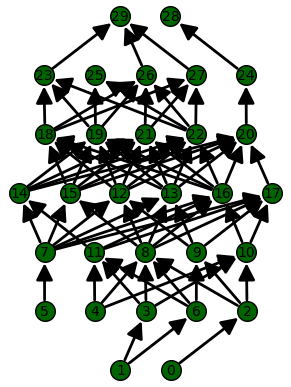

Number of Edges/Amount of Noise Removed: 14
Percentage reduction of symmetric chains by preprocessing step: 72.46%
Found SCD:
[1, 3, 11, 14, 19, 23, 29]
[0, 2, 8, 15, 20, 24, 28]
[5, 7, 12, 18, 26]
[4, 10, 16, 21, 27]
[6, 9, 13, 22, 25]
[17]
---------------------------------------
Generated poset 10
Chain Sizes for the Symmetric Chain Decomposition Would Be: [7, 7, 7, 5, 1, 1]


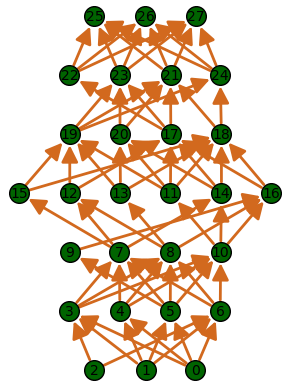

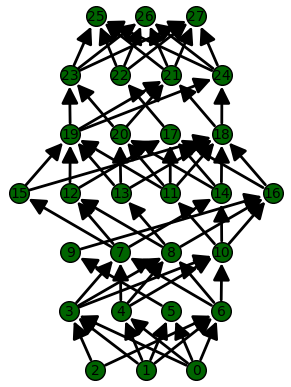

Number of Edges/Amount of Noise Removed: 5
Percentage reduction of symmetric chains by preprocessing step: 39.16%
Found SCD:
[2, 3, 7, 15, 19, 23, 27]
[1, 4, 8, 12, 17, 22, 25]
[0, 5, 9, 16, 18, 24, 26]
[6, 10, 11, 20, 21]
[13]
[14]
---------------------------------------
Generated poset 11
Chain Sizes for the Symmetric Chain Decomposition Would Be: [7, 7, 7, 7, 5, 1]


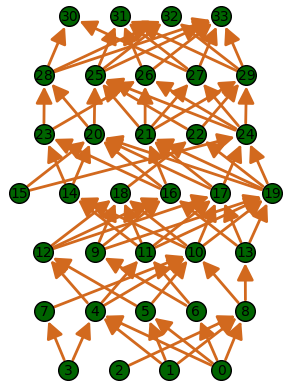

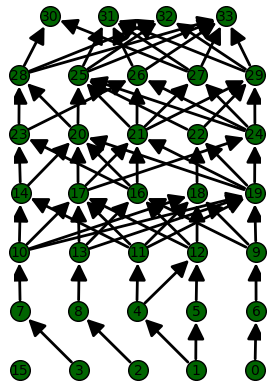

Number of Edges/Amount of Noise Removed: 11
Percentage reduction of symmetric chains by preprocessing step: 68.17%
Found SCD:
[3, 7, 10, 14, 23, 28, 32]
[2, 8, 13, 17, 20, 25, 33]
[1, 4, 11, 18, 22, 29, 31]
[0, 6, 9, 19, 24, 27, 30]
[5, 12, 16, 21, 26]
[15]
---------------------------------------
Generated poset 12
Chain Sizes for the Symmetric Chain Decomposition Would Be: [7, 7, 5, 5, 5, 5]


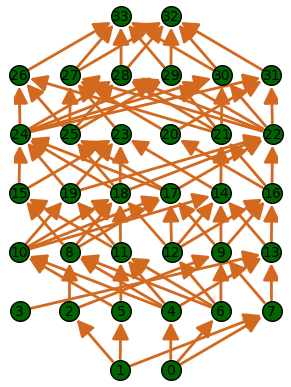

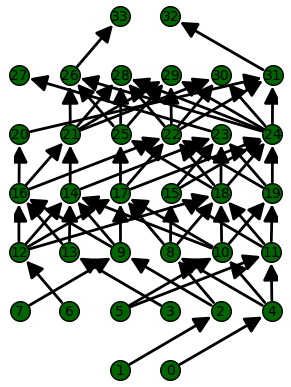

Number of Edges/Amount of Noise Removed: 20
Percentage reduction of symmetric chains by preprocessing step: 70.48%
No valid SCD found
---------------------------------------
Generated poset 13
Chain Sizes for the Symmetric Chain Decomposition Would Be: [7, 7, 5, 5, 3]


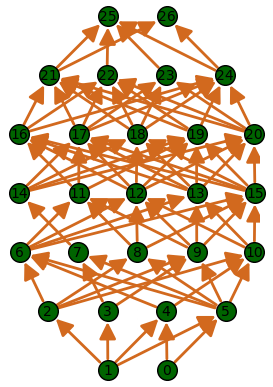

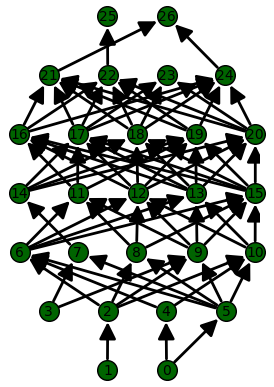

Number of Edges/Amount of Noise Removed: 6
Percentage reduction of symmetric chains by preprocessing step: 47.31%
Found SCD:
[1, 2, 6, 11, 16, 21, 26]
[0, 4, 10, 12, 17, 22, 25]
[3, 7, 14, 18, 23]
[5, 8, 15, 19, 24]
[9, 13, 20]
---------------------------------------
Generated poset 14
Chain Sizes for the Symmetric Chain Decomposition Would Be: [7, 7, 5, 5, 3, 1]


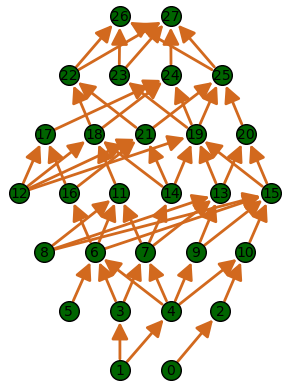

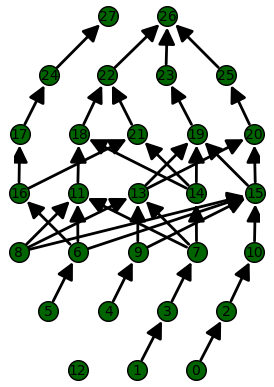

Number of Edges/Amount of Noise Removed: 16
Percentage reduction of symmetric chains by preprocessing step: 73.37%
No valid SCD found
---------------------------------------
Generated poset 15
Chain Sizes for the Symmetric Chain Decomposition Would Be: [7, 7, 5, 3, 3]


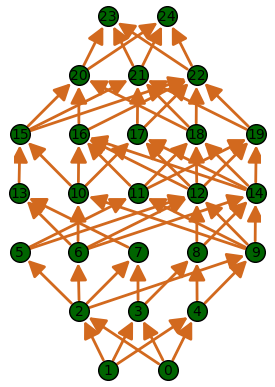

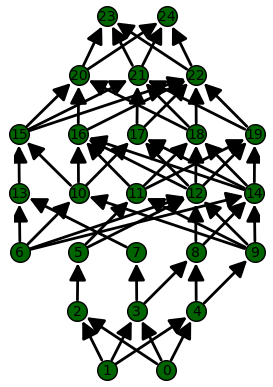

Number of Edges/Amount of Noise Removed: 3
Percentage reduction of symmetric chains by preprocessing step: 39.52%
Found SCD:
[1, 2, 5, 11, 16, 20, 24]
[0, 3, 7, 13, 15, 21, 23]
[4, 8, 12, 18, 22]
[6, 10, 17]
[9, 14, 19]
---------------------------------------
Generated poset 16
Chain Sizes for the Symmetric Chain Decomposition Would Be: [7, 7, 7, 5, 5, 5]


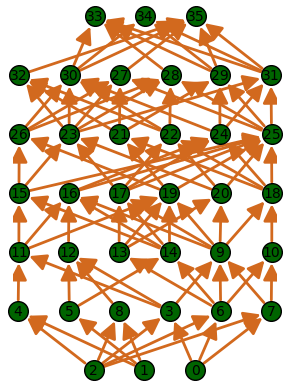

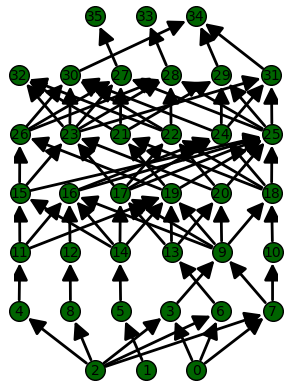

Number of Edges/Amount of Noise Removed: 15
Percentage reduction of symmetric chains by preprocessing step: 66.5%
Found SCD:
[2, 4, 11, 15, 26, 30, 34]
[1, 5, 14, 17, 23, 27, 35]
[0, 3, 9, 19, 25, 28, 33]
[8, 12, 16, 24, 31]
[6, 13, 20, 22, 32]
[7, 10, 18, 21, 29]
---------------------------------------
Generated poset 17
Chain Sizes for the Symmetric Chain Decomposition Would Be: [7, 7, 5, 5, 3]


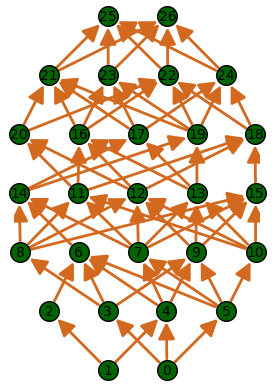

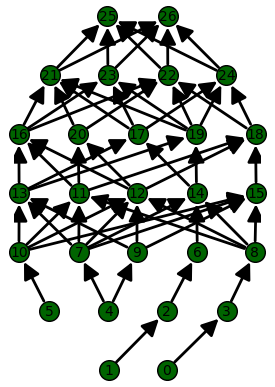

Number of Edges/Amount of Noise Removed: 9
Percentage reduction of symmetric chains by preprocessing step: 72.08%
Found SCD:
[1, 2, 6, 14, 17, 21, 25]
[0, 3, 8, 11, 16, 23, 26]
[5, 10, 13, 19, 22]
[4, 7, 15, 18, 24]
[9, 12, 20]
---------------------------------------
Generated poset 18
Chain Sizes for the Symmetric Chain Decomposition Would Be: [7, 7, 5, 3]


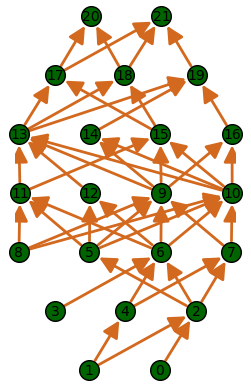

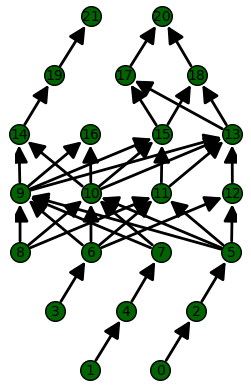

Number of Edges/Amount of Noise Removed: 8
Percentage reduction of symmetric chains by preprocessing step: 72.41%
Found SCD:
[1, 4, 7, 9, 14, 19, 21]
[0, 2, 5, 11, 15, 17, 20]
[3, 6, 12, 13, 18]
[8, 10, 16]
---------------------------------------
Generated poset 19
Chain Sizes for the Symmetric Chain Decomposition Would Be: [7, 7, 7, 5, 5]


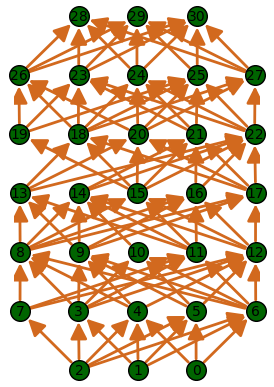

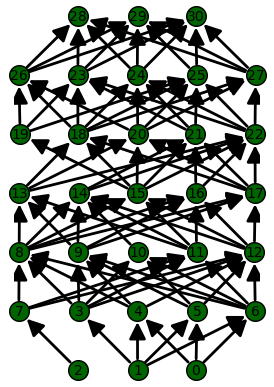

Number of Edges/Amount of Noise Removed: 4
Percentage reduction of symmetric chains by preprocessing step: 29.34%
Found SCD:
[2, 7, 8, 13, 18, 26, 29]
[1, 3, 9, 16, 21, 23, 28]
[0, 4, 12, 17, 20, 24, 30]
[5, 10, 14, 22, 27]
[6, 11, 15, 19, 25]
---------------------------------------
Generated poset 20
Chain Sizes for the Symmetric Chain Decomposition Would Be: [7, 7, 5, 3, 3, 1]


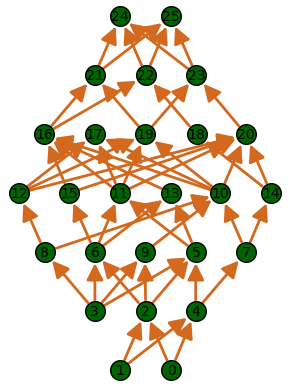

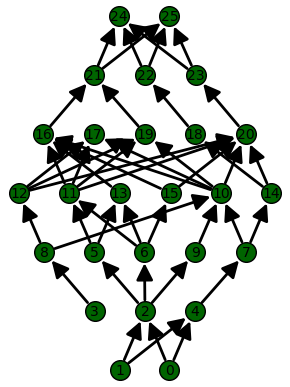

Number of Edges/Amount of Noise Removed: 6
Percentage reduction of symmetric chains by preprocessing step: 46.94%
Found SCD:
[1, 2, 5, 11, 19, 21, 24]
[0, 4, 7, 14, 18, 22, 25]
[3, 8, 12, 20, 23]
[6, 13, 16]
[9, 10, 17]
[15]


In [42]:
"""
Given a desired number of ranks, and a maximum and minimum rank_size, this script generates a specific number of posets, evaluates them and applies noise reduction to them.

INPUTS:
number_of_posets_to_generate (int): The number of posets to generate.
number_of_ranks (int): The number of ranks in each poset.
max_rank_size (int): The maximum size for each rank.
min_rank_size (int): The minimum size for each rank.

OUTPUTS:
Random Peck Posets followed by their  "noise_reduce"d versions
"""

number_of_posets_to_generate = 20
number_of_ranks = random.randint(4,7) #Recommended Range
max_rank_size = random.randint(4,7) #Recommended Range 
min_rank_size = random.randint(1,2) #Recommended Range: 1-2

for i in range(number_of_posets_to_generate):
    # Generate a random rank sizes
    analyzer = PosetAnalyzer([],[],[])
    random_rank_sizes = analyzer.generate_random_rank_sizes(number_of_ranks, max_rank_size, min_rank_size)
    
    # Generate the vertices based on the rank sizes
    vertices = analyzer.make_vertices(random_rank_sizes)

    # Create a new analyzer with these vertices and rank sizes
    analyzer = PosetAnalyzer(vertices, random_rank_sizes, [])
    
    #generate a Peck poset here 
    random_peck_poset, vertices, covering_relations, rank_size_list = analyzer.generate_random_Peck_poset(random_rank_sizes)

    sym_chains = analyzer.symmetric_chains(random_peck_poset)

    print("---------------------------------------")
    print("Generated poset "+str(i+1))
    print(f"Chain Sizes for the Symmetric Chain Decomposition Would Be: {random_peck_poset.greene_shape()}")

    show(random_peck_poset.plot(vertex_colors='darkgreen', edge_color='chocolate'))

    # Create NoiseReducer instance and use it to reduce noise
    reducer = NoiseReducer(vertices, rank_size_list, covering_relations)
    vertices, covering_relations, rank_size_list = reducer.noise_reduce(random_peck_poset)
    
    # Create a new analyzer with the modified poset data
    analyzer = PosetAnalyzer(vertices, rank_size_list, covering_relations)

    current_poset = analyzer.get_current_poset()
    symmetric_chains = analyzer.symmetric_chains(current_poset)

    original_chains = len(sym_chains)
    final_chains = len(symmetric_chains)
    proportion_removed = (original_chains - final_chains) / original_chains

    rd_percentage_removed = round(proportion_removed * 100, 2)

    # print(f"Original # of symmetric chains: {original_chains}")
    # print(f"Final # of symmetric chains: {final_chains}")
    print(f"Percentage reduction of symmetric chains by preprocessing step: {rd_percentage_removed}%")


    # # Find the SCD of the modified poset
    partition = find_SCD_BF(analyzer.symmetric_chains(current_poset), current_poset.greene_shape())
    if partition is not None:
        print("Found SCD:")
        for chain in partition:
            print(chain)
    else:
        print("No valid SCD found")
